In [177]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [178]:
# Paramètres des deux distributions bêta
alpha1, beta1 = 2, 5
alpha2, beta2 = 3, 4

# Création de l'échantillon des valeurs
x = np.linspace(0, 1, 1000)

# Calcul des PDF des deux distributions bêta
pdf1 = beta.pdf(x, alpha1, beta1)
pdf2 = beta.pdf(x, alpha2, beta2)

# Calcul de la probabilité de recouvrement
overlap_surface = np.minimum(pdf1, pdf2)
overlap_prob = np.trapz(np.minimum(pdf1, pdf2), x)

print("Probabilité de recouvrement entre les deux distributions bêta :", overlap_prob)


Probabilité de recouvrement entre les deux distributions bêta : 0.6707826352275587


Text(0.5, 1.0, 'overlap=0.67')

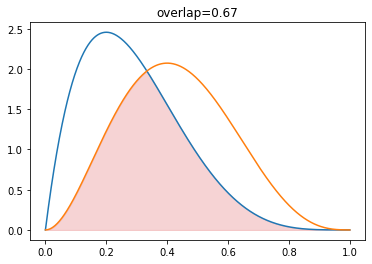

In [179]:
plt.plot(x, pdf1)
plt.plot(x, pdf2)
plt.fill_between(x, np.zeros_like(overlap_surface), overlap_surface, color='tab:red', alpha=.2)
plt.title(f'overlap={overlap_prob:.2f}')

## Implication : A--> B (H1) et A --> non-B (H0)

In [184]:
def log_likelihood(q, x):
    # Calcul de la log-vraisemblance conditionnelle
    return x * np.log(q) + (1 - x) * np.log(1 - q)

In [260]:
def simple_implication(data):
    plt.figure(figsize=(30,20))
    H0 = ((0,0), (0,1), (1,0))
    #H0 = ((1,0)) #non : A --> B
    H1 = ((0,0), (0,1), (1,1)) # A --> nB
    beta_ = {'H0':[1,1], 'H1':[1,1], 'H_ref':[1,1]}
    log_lik_ref = 0
    log_lik_0 = 0
    log_lik_1 = 0
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
            beta_['H_ref'][0] += 1/2
            h0 = 1
        else:
            beta_['H0'][1] += 1
            beta_['H_ref'][1] += 1/2
            h0 = 0
        
        if obs in H1:
            beta_['H1'][0] += 1
            beta_['H_ref'][0] += 1/2
            h1 = 1
        else:
            beta_['H1'][1] += 1
            beta_['H_ref'][1] += 1/2
            h1 = 0
                
        '''h_ref = int(obs[0]==1 or obs[1] == 1)
        if obs[0]==1 or obs[1] == 1:
            beta_['H_ref'][0] += 1
        else:
            beta_['H_ref'][1] += 1'''
        
        ll, _ = quad(lambda q: log_likelihood(q, h0) * beta.pdf(q, beta_['H0'][0], beta_['H0'][1]), 0, 1) 
        log_lik_0 += ll
        ll, _ = quad(lambda q: log_likelihood(q, h1) * beta.pdf(q, beta_['H1'][0], beta_['H1'][1]), 0, 1) 
        log_lik_1 += ll
        ll, _ = quad(lambda q: log_likelihood(q, h0) * beta.pdf(q, beta_['H_ref'][0], beta_['H_ref'][1]), 0, 1) 
        log_lik_ref += ll * 0.5
        ll, _ = quad(lambda q: log_likelihood(q, h1) * beta.pdf(q, beta_['H_ref'][0], beta_['H_ref'][1]), 0, 1) 
        log_lik_ref += ll * 0.5
        
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        ax.plot(x, pdf_H0, label=r'H0: $A \rightarrow \neg B$', color='tab:orange')
        ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B$', color='tab:blue')
        overlap_surface = np.minimum(pdf_H0, pdf_H1)
        overlap_prob = np.trapz(np.minimum(pdf_H0, pdf_H1), x)
        ax.fill_between(x, np.zeros_like(overlap_surface), overlap_surface, color='tab:red', alpha=.2)
        
        #KL_0 = np.sum(np.where(pdf_H0 != 0, pdf_H0 * np.log(pdf_H0 / pdf_ref), 0))
        KL_0, _ = quad(lambda q: beta.pdf(q, beta_['H0'][0], beta_['H0'][1]) * np.log(beta.pdf(q, beta_['H0'][0], beta_['H0'][1])/ beta.pdf(q, i+1, 1)), 0, 1)
        print(i+1, "FE 0:", log_lik_0, KL_0)
        FE_0 = - log_lik_0 + KL_0
        #KL_1 = np.sum(np.where(pdf_H1 != 0, pdf_H1 * np.log(pdf_H1 / pdf_ref), 0))
        KL_1, _ = quad(lambda q: beta.pdf(q, beta_['H1'][0], beta_['H1'][1]) * np.log(beta.pdf(q, beta_['H1'][0], beta_['H1'][1])/ beta.pdf(q, i+1, 1)), 0, 1)
        FE_1 = - log_lik_1 + KL_1
        print(i+1, "FE 1:", log_lik_1, KL_1)
        
        KL_ref, _ = quad(lambda q: beta.pdf(q, beta_['H_ref'][0], beta_['H_ref'][1]) * np.log(beta.pdf(q, beta_['H_ref'][0], beta_['H_ref'][1])/ beta.pdf(q, 1, 1)), 0, 1)
        FE_ref = - log_lik_ref + 0 * KL_ref
        print(i+1, "FE ref:", log_lik_ref, KL_ref)
        
        ax.set_title(f'#{i+1}, FE_ref:{FE_ref:.2f}, FE_0:{FE_0:.2f}, FE_1:{FE_1:.2f}')
        ax.text(0.05,4.5,f'A={obs[0]}')
        ax.text(0.05,4.1,f'B={obs[1]}')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)

    

In [261]:
# (A,B) observations
data = ((0,1), (1,0), (0,0), (1,1), (1,1), (1,1), (0,1), (0,0), (1,1), (1,1))

1 FE 0: -0.49999999999999983 0.19314718055994534
1 FE 1: -0.49999999999999983 0.19314718055994534
1 FE ref: -0.49999999999999983 0.19314718055994534
2 FE 0: -0.8333333333332017 0.07213177477496269
2 FE 1: -1.3333333333333335 0.26527895533477636
2 FE ref: -1.3862943611172773 0.18860344751651836
3 FE 0: -1.083333333331637 0.0376820724533455
3 FE 1: -1.9166666666661591 0.30296102778655903
3 FE ref: -1.7892553888966551 0.3556460489487788
4 FE 0: -2.3666666666649587 0.3261045791007788
4 FE 1: -2.3666666666582494 0.3261045791007788
4 FE ref: -2.655922055559361 0.36239894022110786
5 FE 0: -3.3166666666646467 1.201573316430756
5 FE 1: -2.733333333329157 0.3417594692281055
5 FE ref: -3.482692607154732 0.3926932984212882
6 FE 0: -4.076190476184976 2.390359143860918
6 FE 1: -3.0428571428528124 0.3530530061983724
6 FE ref: -4.283883083345172 0.4301508263462821
7 FE 0: -4.710714285710039 2.3043556445939295
7 FE 1: -3.3107142857099623 0.36158439882405435
7 FE ref: -4.718406892868343 0.51563064607019

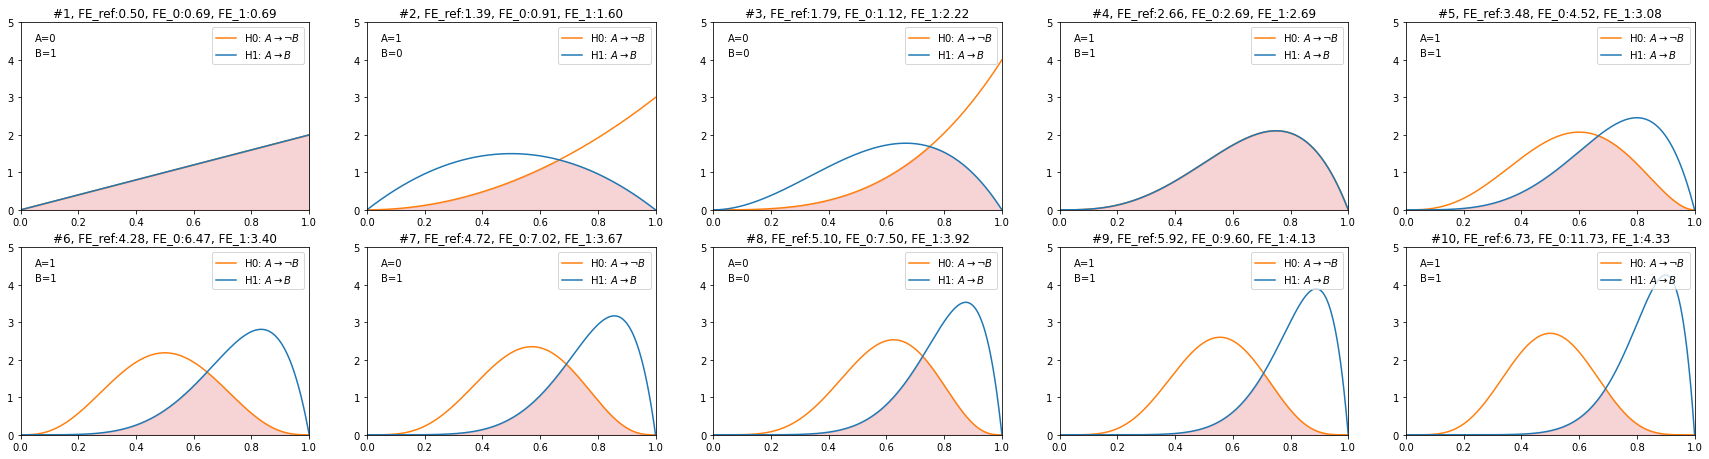

In [262]:
simple_implication(data)

### Baseline

In [263]:
data = ((1,1), (1,1), (1,1), (1,1), (1,1))

1 FE 0: -0.4999999999999997 0.1931471805599453
1 FE 1: -0.49999999999999983 0.19314718055994534
1 FE ref: -0.8862943611184942 0.048417294710598115
2 FE 0: -0.8333333333332016 1.5721317747751244
2 FE 1: -0.8333333333332017 0.07213177477496269
2 FE ref: -1.7196276944518278 0.12509280256138822
3 FE 0: -1.0833333333316368 3.704348739123134
3 FE 1: -1.083333333331637 0.0376820724533455
3 FE ref: -2.5225887222245023 0.19980500604244797
4 FE 0: -1.283333333332326 6.2731435513141305
4 FE 1: -1.283333333332326 0.02314355131352061
4 FE ref: -3.3059220555576774 0.2678640483291799
5 FE 0: -1.4499999999989712 9.148988223460671
5 FE 1: -1.4499999999989714 0.015654890127309393
5 FE ref: -4.075549750009144 0.32916553505469875


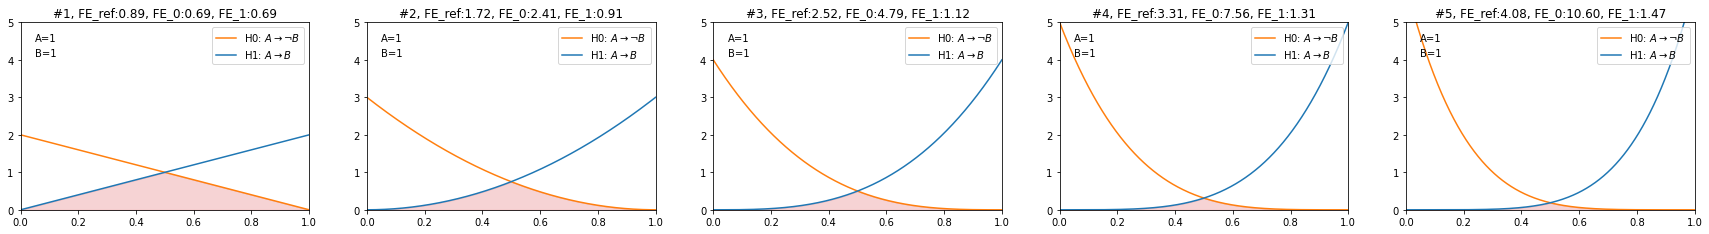

In [264]:
simple_implication(data)

### US preexposure effect

In [230]:
# (A,B) observations
data = ((0,1), (0,1), (0,1), (0,1), (0,1), (1,1), (1,1), (1,1), (1,1), (1,1))
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

1 FE 0: -0.49999999999999983 0.0
1 FE 1: -0.49999999999999983 0.0
1 FE ref: -0.49999999999999983 0
2 FE 0: -0.8333333333332017 0.0
2 FE 1: -0.8333333333332017 0.0
2 FE ref: -0.8333333333332017 0
3 FE 0: -1.083333333331637 0.0
3 FE 1: -1.083333333331637 0.0
3 FE ref: -1.083333333331637 0
4 FE 0: -1.283333333332326 0.0
4 FE 1: -1.283333333332326 0.0
4 FE ref: -1.283333333332326 0
5 FE 0: -1.4499999999989714 0.0
5 FE 1: -1.4499999999989714 0.0
5 FE ref: -1.4499999999989714 0
6 FE 0: -1.7595238095226267 0.11262141277328308
6 FE 1: -1.5928571428561151 0.18752861021181005
6 FE ref: -1.6727301475449798 0
7 FE 0: -2.194047619045798 0.3152789553348762
7 FE 1: -1.7178571428561151 0.6469469938019787
7 FE ref: -1.9405872904021297 0
8 FE 0: -2.739682539678739 0.5647958952226781
8 FE 1: -1.8289682539672263 1.2912299187316982
8 FE ref: -2.245582395221591 0
9 FE 0: -3.385317460313585 0.8527629684948681
9 FE 1: -1.9289682539672262 2.0744175694794347
9 FE ref: -2.5816935063327002 0
10 FE 0: -4.121861471

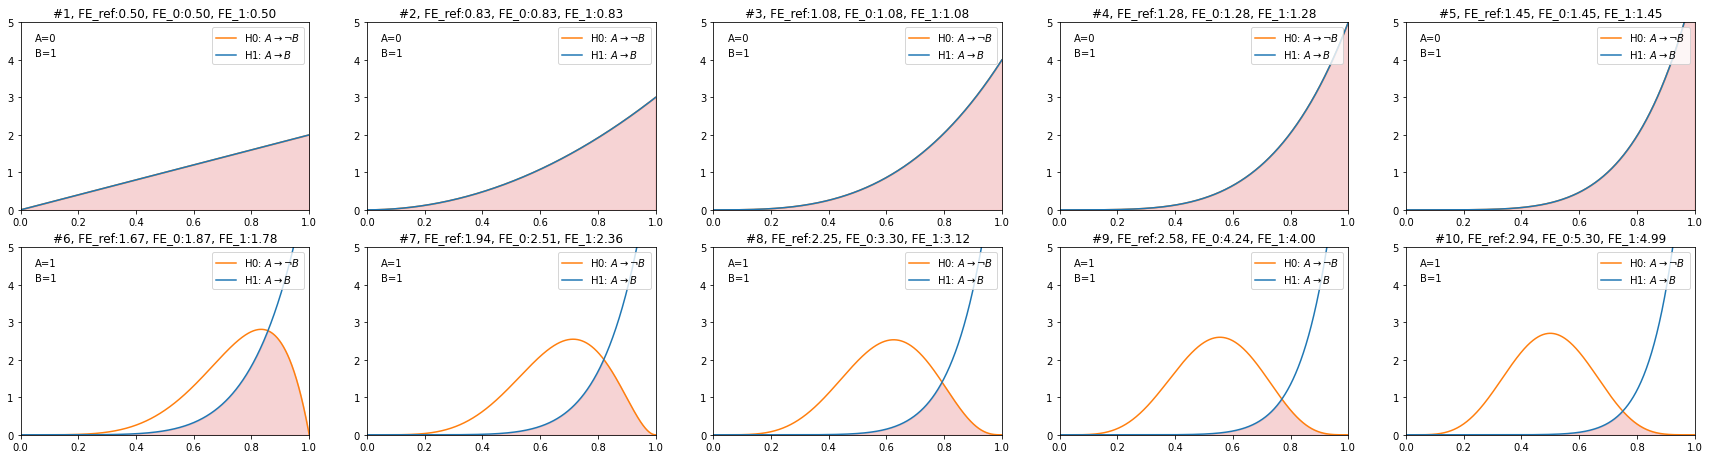

In [231]:
simple_implication(data)

### CS preexposure effect

In [206]:
# (A,B) observations
data = ((1,0), (1,0), (1,0), (1,0), (1,0), (1,1), (1,1), (1,1), (1,1), (1,1),)
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

1 FE 0: -1.5000000000000002 0.401387711331891
1 FE 1: -0.4999999999999997 0.40138771133189033
1 FE ref: -1.5000000000000002 0
2 FE 0: -3.3333333333333304 1.364081573672616
2 FE 1: -0.8333333333332016 1.3640815736726184
2 FE ref: -3.3333333333333304 0
3 FE 0: -5.416666666666657 2.6946519385105745
3 FE 1: -1.0833333333316368 2.6946519385105883
3 FE ref: -5.416666666666657 0
4 FE 0: -7.69999999999999 4.297051426381845
4 FE 1: -1.283333333332326 4.2970514263818735
4 FE ref: -7.69999999999999 0
5 FE 0: -10.149999999999991 6.114435108918274
5 FE 1: -1.4499999999989712 6.114435108918317
5 FE ref: -10.149999999999991 0
6 FE 0: -10.459523809523647 2.617817712988661
6 FE 1: -3.0428571428559135 2.6178177129886633
6 FE ref: -10.459523809523647 0
7 FE 0: -10.894047619046818 1.2333486510259595
7 FE 1: -4.260714285712946 1.2333486510259593
7 FE ref: -10.894047619046818 0
8 FE 0: -11.439682539679758 0.5417879885003527
8 FE 1: -5.2563492063352015 0.5417879885003524
8 FE ref: -11.439682539679758 0
9 FE 

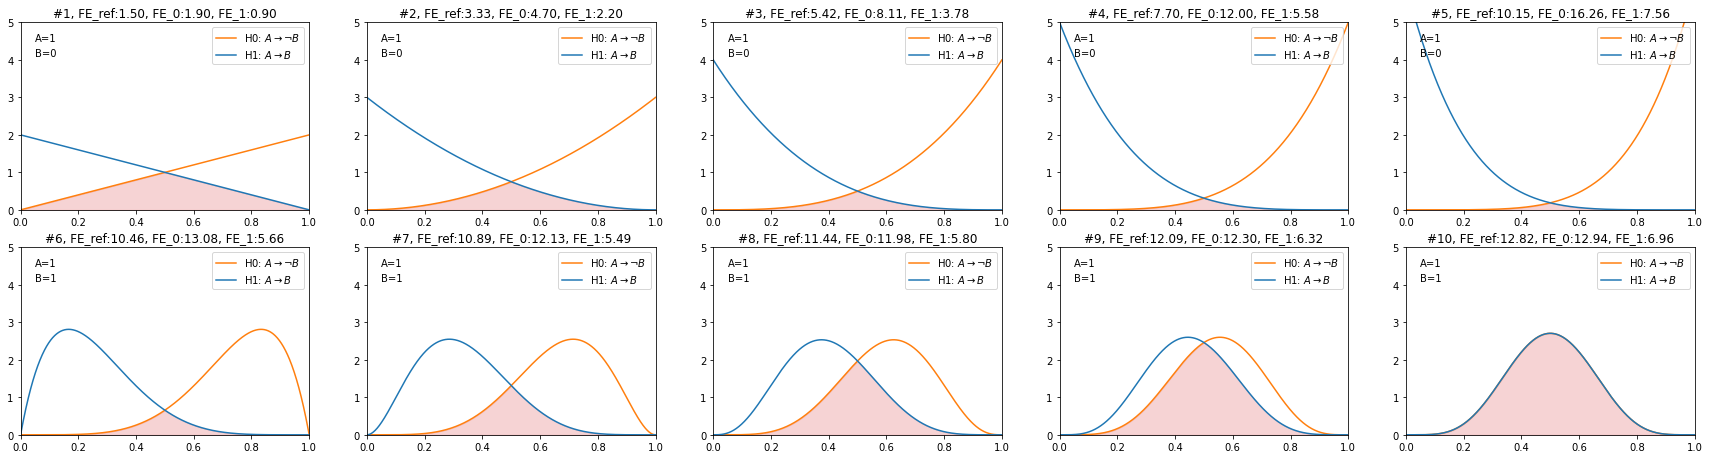

In [207]:
simple_implication(data)

## Cue competition : A, X, --> B

  * H0 : non(A --> B) ou non(X --> B) : (A et non-B) ou (X et non-B)
  * H1 : A --> B et X --> B : (non-A ou B) et (non-X ou B) : (non-A et non-X) ou (non-A et B) ou (B et non-X) ou B   
                                                           : (non-A et non-X) ou B 
  * H0 : (A ou X) --> non-B : non(A ou X) ou non-B : (non-A et non-X) ou non-B
  * H1 : (A ou X) --> B : non(A ou X) ou B : (non-A et non-X) ou B
  * H2 : A --> B : non(A)  ou B 
  * H3 : X --> B : non(X) ou B 
 


In [12]:
def cue_competition_implication(data):
    plt.figure(figsize=(30,20))
    H0 = ((0,0,0), (0,0,1),
      (0,1,0),(0,1,1),(1,0,0),(1,1,0))
    H1 = ((0,0,0), (0,0,1),
      (0,1,0),(1,0,0),(1,0,1),(1,1,0))
    
    H2 = ((0,0,0), (0,1,0), (0,0,1), (0,1,1),
      (1,0,1), (1,1,1))
   
    H3 = ((0,0,0), (1,0,0), (0,0,1), (1,0,1),
      (0,1,1), (1,1,1))
    beta_ = {'H0':[1,1], 'H1':[1,1],'H2':[1,1], 'H3':[1,1]}
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
        else:
            beta_['H0'][1] += 1
        if obs in H1:
            beta_['H1'][0] += 1
        else:
            beta_['H1'][1] += 1
        if obs in H2:
            beta_['H2'][0] += 1
        else:
            beta_['H2'][1] += 1
        if obs in H3:
            beta_['H3'][0] += 1
        else:
            beta_['H3'][1] += 1
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        pdf_H2 = beta.pdf(x, beta_['H2'][0], beta_['H2'][1])
        pdf_H3 = beta.pdf(x, beta_['H3'][0], beta_['H3'][1])
        #ax.plot(x, pdf_H0, label=r'H0: $\neg (A \rightarrow B) \vee \neg (X \rightarrow B)$', color='tab:orange')
        #ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B \wedge X \rightarrow B$', color='tab:blue')
        ax.plot(x, pdf_H0-0.03, label=r'H0: $A   \rightarrow \neg B$', color='tab:orange')
        ax.plot(x, pdf_H1, label=r'H1: $X  \rightarrow \neg B$', color='tab:red')
        ax.plot(x, pdf_H2+0.03, label=r'H2: $A \rightarrow B$', color='tab:green')
        ax.plot(x, pdf_H3+0.06, label=r'H3: $X \rightarrow B$', color='tab:purple')
        overlap_surface_1 = np.minimum(pdf_H0, pdf_H2)
        overlap_surface_2 = np.minimum(pdf_H1, pdf_H3)
        overlap_prob_1 = np.trapz(np.minimum(pdf_H0, pdf_H2), x)
        overlap_prob_2 = np.trapz(np.minimum(pdf_H1, pdf_H3), x)
        ax.fill_between(x, np.zeros_like(overlap_surface_1), overlap_surface_1, color='tab:green', alpha=.2)
        ax.fill_between(x, np.zeros_like(overlap_surface_2), overlap_surface_2, color='tab:purple', alpha=.2)
        ax.set_title(f'#{i+1}, ovl1={overlap_prob_1:.2f}, ovl2={overlap_prob_2:.2f}')
        ax.text(0.05,4.5,f'A={obs[0]}')
        ax.text(0.05,4.1,f'X={obs[1]}')
        ax.text(0.05,3.7,f'B={obs[2]}')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)

    

In [13]:
data = ((1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,0,0), (1,0,0), (1,0,0), (1,0,0), (1,0,0))

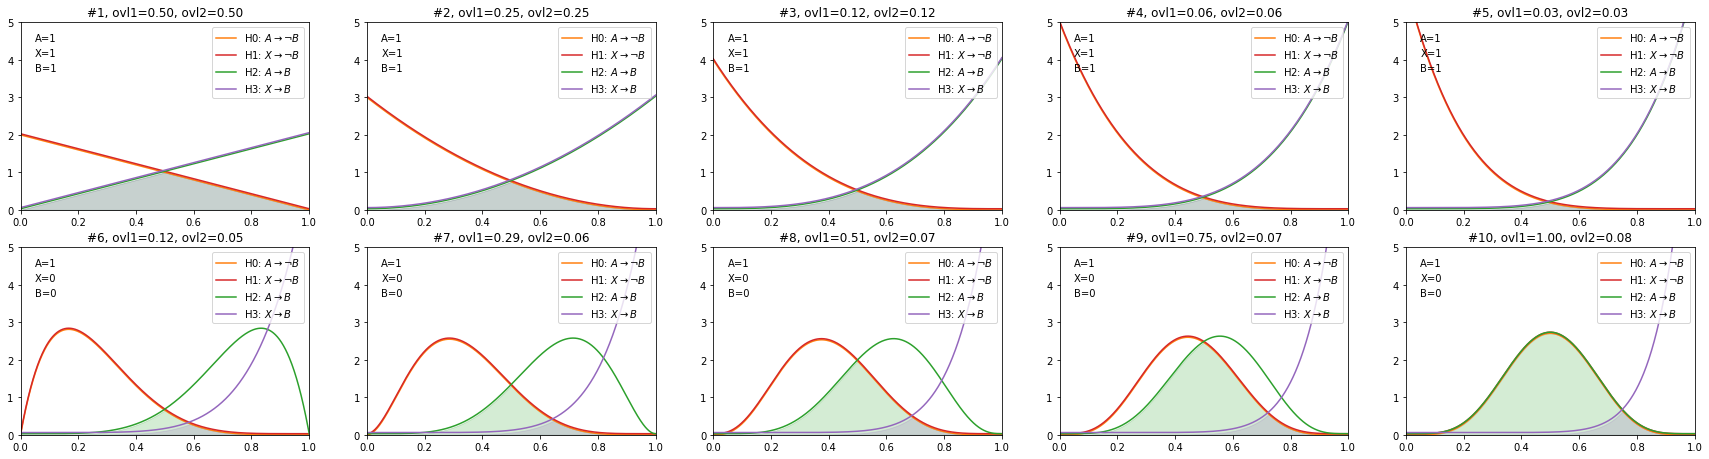

In [14]:
cue_competition_implication(data)

## Blocking

In [15]:
data = ((1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1))

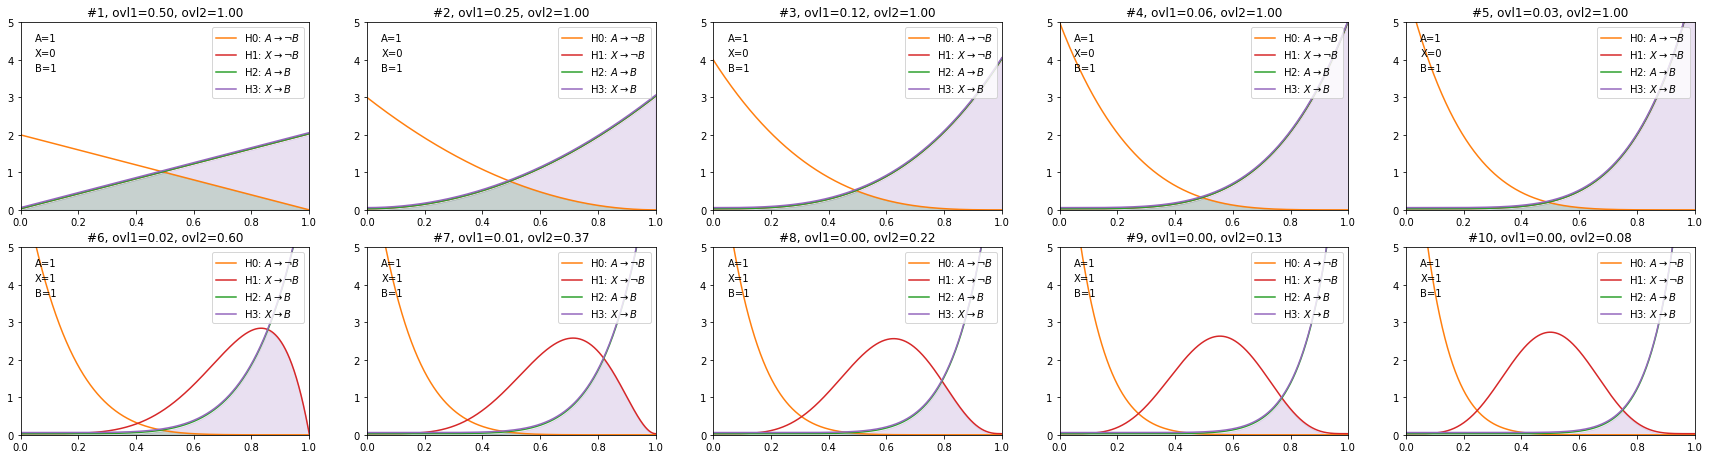

In [16]:
cue_competition_implication(data)

## Retrospective reevaluation : A, X, --> B

In [23]:
data = ((1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,0,0), (1,0,0), (1,0,0), (1,0,0), (1,0,0))

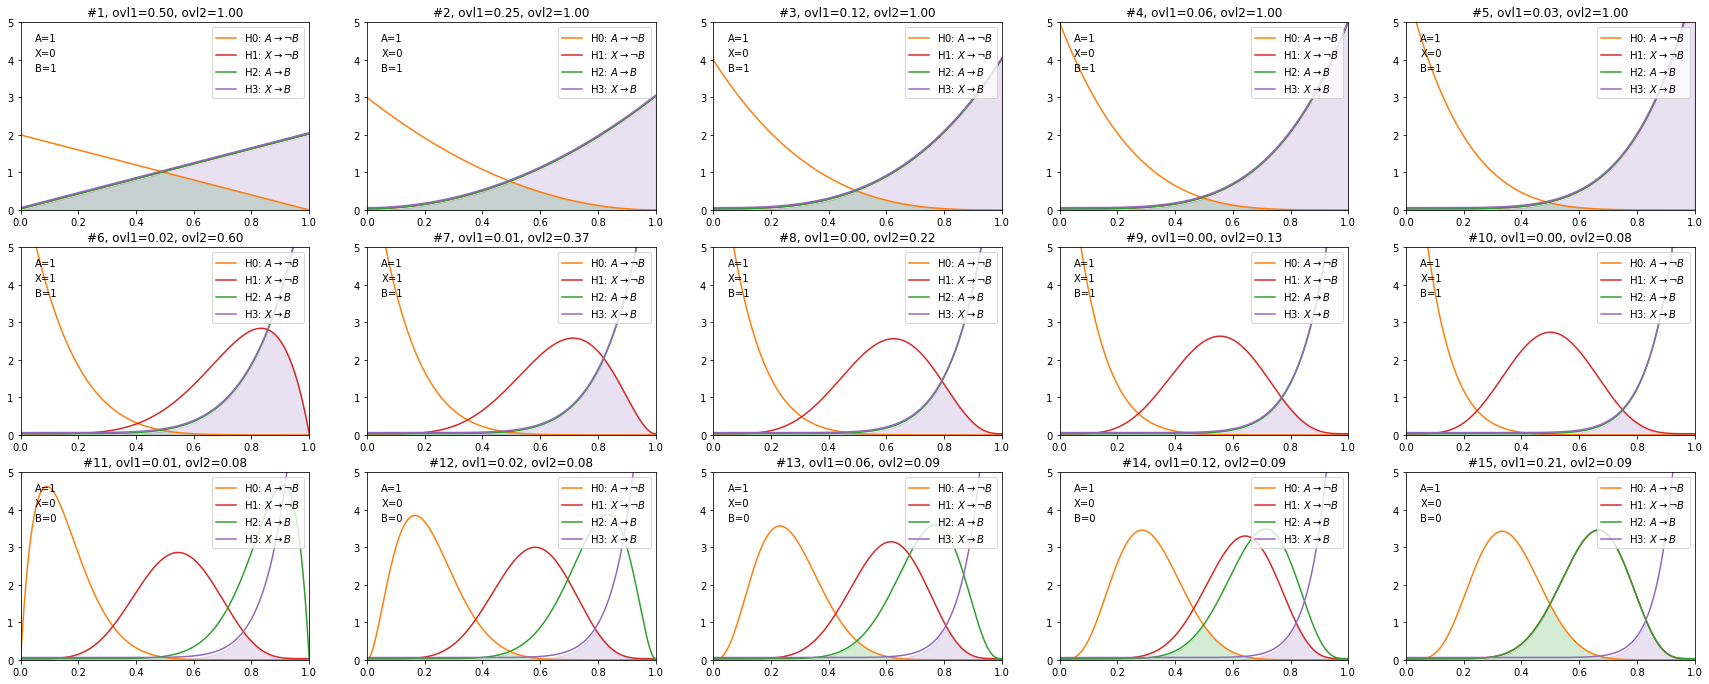

In [24]:
cue_competition_implication(data)

## Modelling contextual effect (Renewal)

H0 = A --> B = non-A ou B 

H1 = C1 --> (A --> B) = C1 --> non-A ou B = non-C1 ou (non-A ou B) 

H2 = C2 --> (A --> non-B) = C2 --> non-A ou non-B = non-C2 ou (non-A ou non-B) 

In [57]:
def contextual_effect_implication(data):
    plt.figure(figsize=(30,20))
    H0 = ((0,0,0,0), (0,0,0,1), (0,0,1,1),
      (0,1,0,0), (0,1,0,1), (0,1,1,1),
      (1,0,0,0), (1,0,0,1), (1,0,1,1),
      (1,1,0,0), (1,1,0,1), (1,1,1,1),)
    #H0 = ((1,0)) #non : A --> B
    H1 = ((0,0,0,0), (0,0,0,1), (0,0,1,0), (0,0,1,1),
          (0,1,0,0), (0,1,0,1), (0,1,1,0), (0,1,1,1),
          (1,0,0,0), (1,0,0,1), (1,0,1,1),
          (1,1,0,0), (1,1,0,1), (1,1,1,1))
    H2 = ((0,0,0,0), (0,0,0,1), (0,0,1,0), (0,0,1,0),
          (1,0,0,0), (1,0,0,1), (1,0,1,0), (1,0,1,1),
          (0,1,0,0), (0,1,0,1), (0,1,1,0),
          (1,1,0,0), (1,1,0,1), (1,1,1,0))
    beta_ = {'H0':[1,1], 'H1':[1,1], 'H2':[1,1]}
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
        else:
            beta_['H0'][1] += 1
        if obs in H1:
            beta_['H1'][0] += 1
        else:
            beta_['H1'][1] += 1
        if obs in H2:
            beta_['H2'][0] += 1
        else:
            beta_['H2'][1] += 1
        
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        pdf_H2 = beta.pdf(x, beta_['H2'][0], beta_['H2'][1])
        #ax.plot(x, pdf_H0, label=r'H0: $\neg (A \rightarrow B) \vee \neg (X \rightarrow B)$', color='tab:orange')
        #ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B \wedge X \rightarrow B$', color='tab:blue')
        ax.plot(x, pdf_H0, label=r'H0: $A \rightarrow B$', color='tab:orange')
        ax.plot(x, pdf_H1+0.03, label=r'H1: $C1 \rightarrow (A \rightarrow B)$', color='tab:red')
        ax.plot(x, pdf_H2+0.06, label=r'H2: $C2 \rightarrow (A \rightarrow \neg B)$', color='tab:green')
        overlap_surface_1 = np.minimum(pdf_H0, pdf_H1)
        overlap_surface_2 = np.minimum(pdf_H0, pdf_H2)
        overlap_prob_1 = np.trapz(np.minimum(pdf_H0, pdf_H1), x)
        overlap_prob_2 = np.trapz(np.minimum(pdf_H0, pdf_H2), x)
        ax.fill_between(x, np.zeros_like(overlap_surface_1), overlap_surface_1, color='tab:green', alpha=.2)
        ax.fill_between(x, np.zeros_like(overlap_surface_2), overlap_surface_2, color='tab:purple', alpha=.2)
        ax.set_title(f'#{i+1}, ovl1={overlap_prob_1:.2f}, ovl2={overlap_prob_2:.2f}')
        ax.text(0.05,4.5,f'C1={obs[0]}')
        ax.text(0.05,4.1,f'C2={obs[1]}')
        ax.text(0.05,3.7,f'A={obs[2]}')
        ax.text(0.05,3.3,f'B={obs[3]}')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)


In [58]:
# (C1, C2, A, B) observations
data = ((1,0,1,1), (1,0,1,1), (1,0,1,1), (1,0,1,1), (1,0,1,1), (0,1,1,0), (0,1,1,0), (0,1,1,0), (0,1,1,0), (0,1,1,0))
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

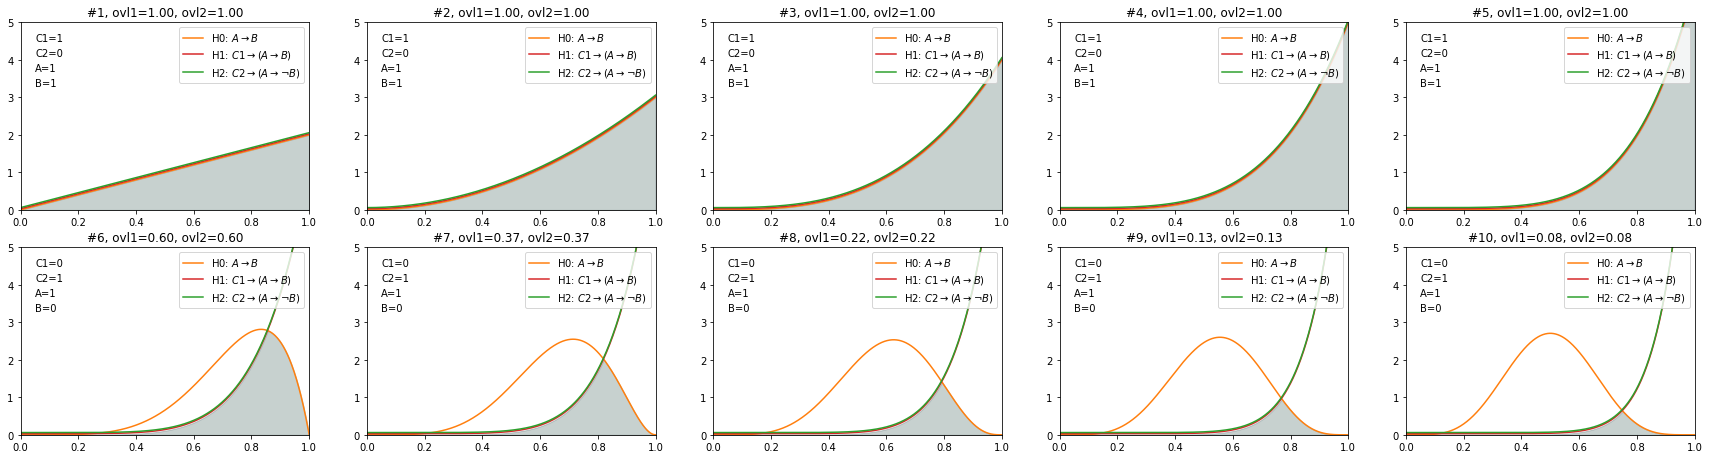

In [60]:
contextual_effect_implication(data)